**Verificando a estrutura geral do CSV a partir da leitura de suas primeiras linhas** <b>
    
bernardogontijovazguimaraes ativ_pontuada_1 % head 34-1arquivo.log.labeled.csv
ts|uid|id.orig_h|id.orig_p|id.resp_h|id.resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|label|detailed-label
1545403816.962094|CrDn63WjJEmrWGjqf|192.168.1.195|41040|185.244.25.235|80|tcp|-|3.139211|0|0|S0|-|-|0|S|3|180|0|0|-|Benign|-
1545403824.181240|CY9lJW3gh1Eje4usP6|192.168.1.195|41040|185.244.25.235|80|tcp|-|-|-|-|S0|-|-|0|S|1|60|0|0|-|Benign|-
1545403832.341331|CcFXLynukEDnUlvgl|192.168.1.195|41040|185.244.25.235|80|tcp|-|-|-|-|S0|-|-|0|S|1|60|0|0|-|Benign|-
1545403848.981338|CDrkrSobGYxHhYfth|192.168.1.195|41040|185.244.25.235|80|tcp|http|1.477656|149|128252|SF|-|-|2896|ShADadttcfF|94|5525|96|139044|-|Benign|-
1545403850.554283|CTWZQf2oJSvq6zmPAc|192.168.1.195|41042|185.244.25.235|80|tcp|-|3.147116|0|0|S0|-|-|0|S|3|180|0|0|-|Benign|-
1545403857.781320|CvyynC4Sabj9BNXFRi|192.168.1.195|41042|185.244.25.235|80|tcp|http|1.305004|151|128348|SF|-|-|5792|ShADadttcfF|96|5699|92|133140|-|Benign|-
1545403859.183341|CWYyiA2sgRijwk2jEd|192.168.1.195|41044|185.244.25.235|80|tcp|http|1.004605|148|91961|SF|-|-|2896|ShADadtcfF|67|4148|65|92453|-|Benign|-
1545403860.282392|CYttPy2pqOIcen7UDh|192.168.1.195|41046|185.244.25.235|80|tcp|http|4.129647|148|99303|SF|-|-|5792|ShADadtcfF|75|4412|69|97107|-|Benign|-
1545403864.507242|CYQTGJ1oQvLAxMiUe3|192.168.1.195|41048|185.244.25.235|80|tcp|-|3.114215|0|0|S0|-|-|0|S|3|180|0|0|-|Benign|-

In [468]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [408]:
# Configurações de visualização
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

In [409]:
#Lista que define as colunas a serem carregadas do arquivo

columns = [
    'id.orig_p',
    'id.resp_h',
    'id.resp_p',
    'proto',
    'service',
    'duration',
    'orig_bytes',
    'resp_bytes',
    'conn_state',
    'missed_bytes',
    'history',
    'orig_pkts',
    'orig_ip_bytes',
    'resp_pkts',
    'resp_ip_bytes',
    'label'
]

In [410]:
dtypes = {
    'duration':np.float32,
    'id.orig_p':np.str_,
    'id.resp_h':np.str_,
    'id.resp_p':np.str_
}

In [411]:
file_path = "34-1arquivo.log.labeled.csv"

data = pd.read_csv(file_path, 
                   sep="|", low_memory=False, 
                   dtype = dtypes, 
                   na_values = '-',
                   usecols = columns                  
                  )

print("Dimensões:", data.shape)
print(data.head())
print(data.info())

Dimensões: (23145, 16)
  id.orig_p       id.resp_h id.resp_p proto service  duration  orig_bytes  \
0     41040  185.244.25.235        80   tcp     NaN  3.139211         0.0   
1     41040  185.244.25.235        80   tcp     NaN       NaN         NaN   
2     41040  185.244.25.235        80   tcp     NaN       NaN         NaN   
3     41040  185.244.25.235        80   tcp    http  1.477656       149.0   
4     41042  185.244.25.235        80   tcp     NaN  3.147116         0.0   

   resp_bytes conn_state  missed_bytes      history  orig_pkts  orig_ip_bytes  \
0         0.0         S0             0            S          3            180   
1         NaN         S0             0            S          1             60   
2         NaN         S0             0            S          1             60   
3    128252.0         SF          2896  ShADadttcfF         94           5525   
4         0.0         S0             0            S          3            180   

   resp_pkts  resp_ip_bytes

**Definindo novas colunas para análise**

In [412]:
data['avg_byte_pkts'] = data['orig_bytes'] / data['orig_pkts']

In [413]:
data['hist_len'] = data['history'].apply(
    lambda x : len(x)
)

In [414]:
data['label'].apply(lambda x: x.split(' ')[-1])

0        Benign
1        Benign
2        Benign
3        Benign
4        Benign
          ...  
23140       C&C
23141       C&C
23142    Benign
23143    Benign
23144    Benign
Name: label, Length: 23145, dtype: object

In [415]:
data['label'] = data['label'].apply(
    lambda x: x.split(' ')[-1]
)

**Exploração dos Dados**

In [416]:
data.label.unique()

array(['Benign', 'C&C', 'PartOfAHorizontalPortScan', 'DDoS'], dtype=object)

**Explicação dos valores da coluna Label**

Benign - The "Benign" label denotes connections where no suspicious or malicious activities have been detected.

Malicious C&C - This label indicates that the infected device has established a connection with a Command and Control server. This observation is rooted in the periodic nature of connections or activities such as binary downloads or the exchange of IRC-like or decoded commands.

Malicious PartOfAHorizontalPortScan - This label is employed when connections are involved in a horizontal port scan aimed at gathering information for potential subsequent attacks. The labeling decision hinges on patterns such as shared ports, similar transmitted byte counts, and multiple distinct destination IPs among the connections.

Malicious DDoS - "DDoS" is assigned when the infected device is actively involved in a Distributed Denial of Service attack, identifiable by the volume of flows directed towards a single IP address.

In [417]:
data.proto.value_counts()

proto
tcp    21331
udp     1814
Name: count, dtype: int64

In [418]:
data.service.value_counts()

service
irc     1641
dns      192
http      12
dhcp       2
Name: count, dtype: int64

In [419]:
data.describe()

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,avg_byte_pkts,hist_len
count,5321.000000,5.321000e+03,5321.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000,5321.000000,23145.000000
mean,22.806503,1.478868e+04,350.429431,2.127112,6.375157,3.664312e+03,0.611017,111.218967,12.847436,1.472111
std,722.522339,1.036441e+06,5378.262771,102.490787,178.548725,5.003762e+05,8.305898,2713.082822,81.272724,1.573609
min,0.000497,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,2.075814,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000
50%,3.110974,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000
75%,3.153695,6.200000e+01,243.000000,0.000000,1.000000,7.600000e+01,0.000000,0.000000,10.714286,1.000000
max,48976.820312,7.554662e+07,164266.000000,5792.000000,18444.000000,7.606306e+07,1070.000000,168910.000000,4096.000000,12.000000


In [420]:
data.columns

Index(['id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'service', 'duration',
       'orig_bytes', 'resp_bytes', 'conn_state', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label',
       'avg_byte_pkts', 'hist_len'],
      dtype='object')

Explorar a relação entre os diferentes labels e atributos numéricos

Lista de colunas a serem utilizadas

In [421]:
data.describe().columns

Index(['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts',
       'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'avg_byte_pkts',
       'hist_len'],
      dtype='object')

In [422]:
# Definindo as colunas a serem utilizadas nas operações de agrupar e agregar pelas colunas disponíveis no describe, que são numéricas
lista_agg = list(data.describe().columns)
print(lista_agg)
# e adicionando a coluna label
lista_agg.insert(0,'label')
print(lista_agg)

['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'avg_byte_pkts', 'hist_len']
['label', 'duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'avg_byte_pkts', 'hist_len']


In [423]:
data_labels_agg = data[lista_agg]
#data_labels_agg.head()

In [424]:
data_labels_agg.groupby(['label']).mean()

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,avg_byte_pkts,hist_len
label,,,,,,,,,,
Benign,1.936806,6.108175e+01,1392.474576,25.601664,13.003640,570.797712,1.092564,761.260530,45.410279,1.497660
C&C,27.785528,3.206288e+01,108.985328,0.000000,3.691619,229.573069,1.795556,165.562034,3.405380,2.483448
DDoS,4.823688,5.811279e+06,0.000000,0.000000,4.099764,5397.094345,0.000000,0.000000,315.076923,1.001528
PartOfAHorizontalPortScan,3.365600,2.677295e+05,0.000000,0.000000,317.860656,36783.245902,0.000000,0.000000,372.363636,1.000000


In [425]:
data_labels_agg.groupby(['label']).mean()['duration']

label
Benign                        1.936806
C&C                          27.785528
DDoS                          4.823688
PartOfAHorizontalPortScan     3.365600
Name: duration, dtype: float32

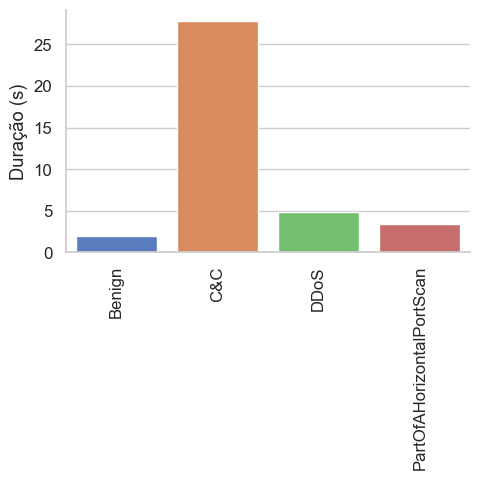

In [426]:
# Gráfico duração da conexão por label

conDur_label = sns.catplot(
    data = data_labels_agg.groupby(['label']).mean(),
    kind = "bar",
    x='label', y='duration',
    hue = 'label',
    errorbar = 'sd'
).set(xlabel=None).set(ylabel='Duração (s)')
plt.xticks(rotation=90)
plt.tight_layout()

In [427]:
data.groupby('label')['proto'].value_counts()

label                      proto
Benign                     udp       1812
                           tcp        111
C&C                        tcp       6706
DDoS                       tcp      14393
                           udp          1
PartOfAHorizontalPortScan  tcp        121
                           udp          1
Name: count, dtype: int64

In [428]:
data.groupby('label')['proto'].value_counts().reset_index()

,label,proto,count
0,Benign,udp,1812
1,Benign,tcp,111
2,C&C,tcp,6706
3,DDoS,tcp,14393
4,DDoS,udp,1
5,PartOfAHorizontalPortScan,tcp,121
6,PartOfAHorizontalPortScan,udp,1


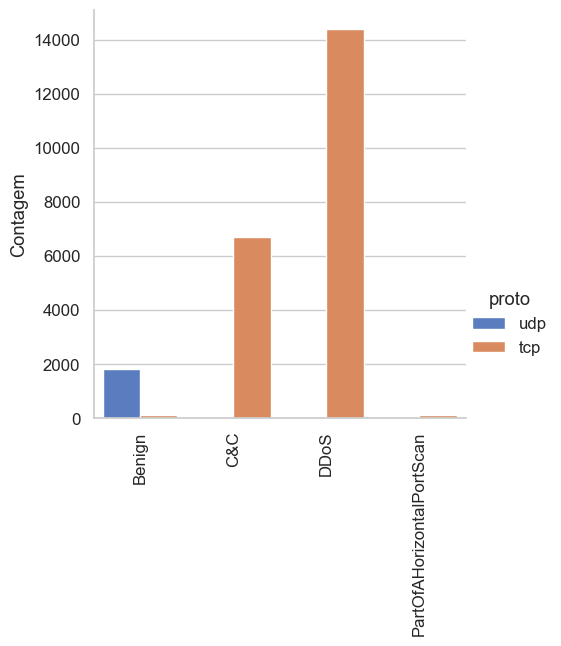

In [429]:
# Gráfico número de requisições por tipo protocolo e label

conDur_label = sns.catplot(
    data = data.groupby('label')['proto'].value_counts().reset_index(),
    kind = "bar",
    x='label', y='count',
    hue = 'proto'
).set(xlabel=None,
      ylabel='Contagem',
     )
plt.xticks(rotation=90);

**Connection States**

S0 - Connection attempt seen, no reply

S1 - Connection established, not terminated (0 byte counts)

S3 - Established, response attempts close, no reply from Orig

SF - Normal Establish & termination (>0 bytes counts)

RSTR - established, response aborted (RST)

OTH - No SYN, not closed. Midstream traffic. Partial connection.

In [494]:
general_connstate = data.groupby('label')['conn_state'].value_counts().reset_index()
general_connstate

,label,conn_state,count
0,Benign,S0,1074
1,Benign,SF,849
2,C&C,S0,5065
3,C&C,S3,1584
4,C&C,RSTR,53
5,C&C,S1,4
6,DDoS,OTH,14260
7,DDoS,S0,134
8,PartOfAHorizontalPortScan,S0,122


In [431]:
benign_connState = data[data['label'] == 'Benign'].groupby('label')['conn_state'].value_counts().reset_index()
benign_connState

,label,conn_state,count
0,Benign,S0,1074
1,Benign,SF,849


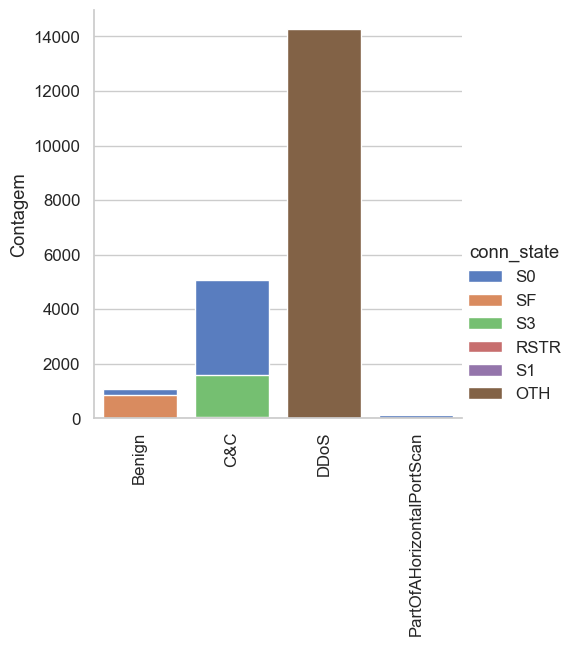

In [496]:
conDur_label = sns.catplot(
    data = general_connstate,
    kind = "bar",
    x='label', y='count',
    hue = 'conn_state',
    dodge=False
).set(xlabel=None,
      ylabel='Contagem',
     )
plt.xticks(rotation=90);

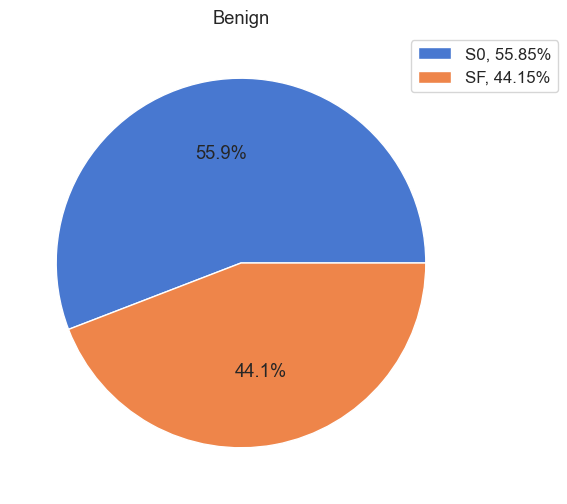

In [432]:
fig, ax = plt.subplots()
plt.title('Benign')
ax.pie(benign_connState['count'],
       autopct='%1.1f%%'
      );
labels = [f'{l}, {s*100/benign_connState['count'].sum():.2f}%' for l, s in zip(benign_connState.conn_state, benign_connState['count'])]
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels);

In [433]:
cec_connState = data[data['label'] == 'C&C'].groupby('label')['conn_state'].value_counts().reset_index()
cec_connState

,label,conn_state,count
0,C&C,S0,5065
1,C&C,S3,1584
2,C&C,RSTR,53
3,C&C,S1,4


In [434]:
cec_connState['count'].sum()

np.int64(6706)

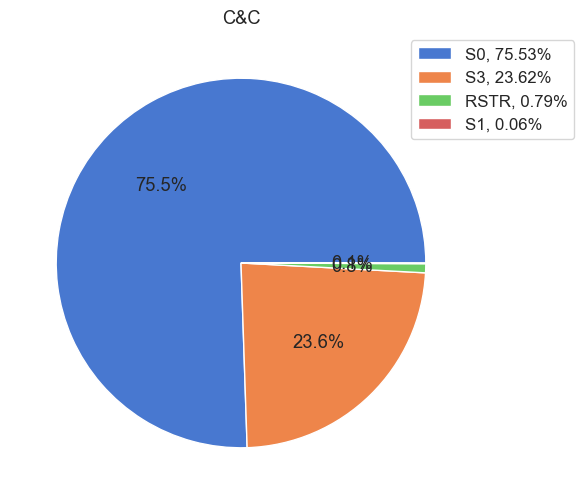

In [435]:
fig, ax = plt.subplots()
plt.title('C&C')
ax.pie(cec_connState['count'],
       autopct='%1.1f%%'
      );
labels = [f'{l}, {s*100/cec_connState['count'].sum():.2f}%' for l, s in zip(cec_connState.conn_state, cec_connState['count'])]
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels);

In [436]:
ddos_connState = data[data['label'] == 'DDoS'].groupby('label')['conn_state'].value_counts().reset_index()
ddos_connState

,label,conn_state,count
0,DDoS,OTH,14260
1,DDoS,S0,134


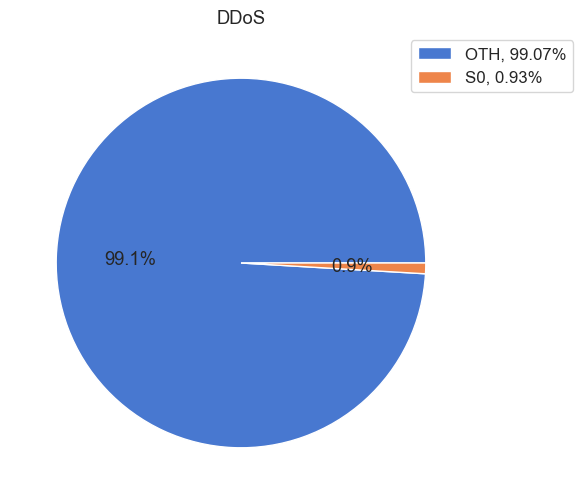

In [437]:
fig, ax = plt.subplots()
plt.title('DDoS')
ax.pie(ddos_connState['count'],
       autopct='%1.1f%%'
      );
labels = [f'{l}, {s*100/ddos_connState['count'].sum():.2f}%' for l, s in zip(ddos_connState.conn_state, ddos_connState['count'])]
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels);

In [438]:
porScan_connState = data[data['label'] == 'PartOfAHorizontalPortScan'].groupby('label')['conn_state'].value_counts().reset_index()
porScan_connState

,label,conn_state,count
0,PartOfAHorizontalPortScan,S0,122


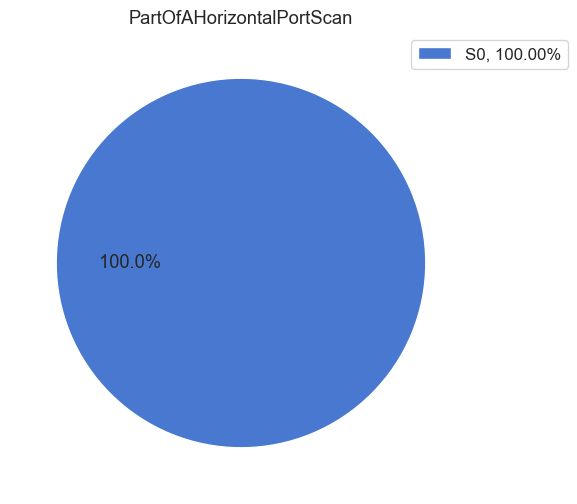

In [439]:
fig, ax = plt.subplots()
plt.title('PartOfAHorizontalPortScan')
ax.pie(porScan_connState['count'],
       autopct='%1.1f%%'
      );
labels = [f'{l}, {s*100/porScan_connState['count'].sum():.2f}%' for l, s in zip(porScan_connState.conn_state, porScan_connState['count'])]
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels);

In [440]:
history_count = data.groupby('label')['history'].value_counts().reset_index()
history_count[history_count['count'] > 50]

,label,history,count
0,Benign,D,976
1,Benign,Dd,836
2,Benign,S,98
10,C&C,S,5065
11,C&C,ShAdDaf,1477
12,C&C,ShAdDaft,102
24,DDoS,C,14252
25,DDoS,S,133
29,PartOfAHorizontalPortScan,S,121


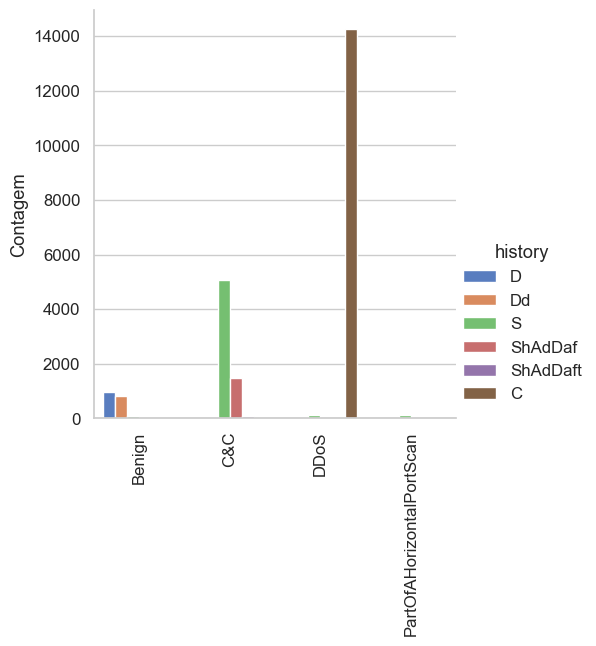

In [492]:
his_count_label = sns.catplot(
    data = history_count[history_count['count'] > 50],
    kind = "bar",
    x='label', y='count',
    hue = 'history'
).set(xlabel=None).set(ylabel='Contagem')
plt.xticks(rotation=90);

In [442]:
data.groupby('label')['id.orig_p'].nunique().reset_index()

,label,id.orig_p
0,Benign,247
1,C&C,4055
2,DDoS,146
3,PartOfAHorizontalPortScan,106


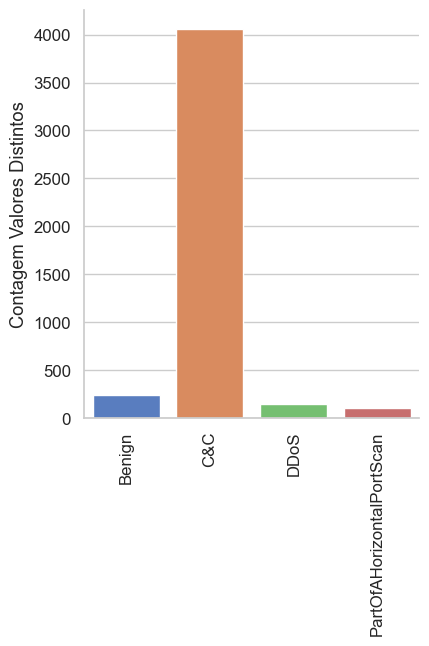

In [493]:
origPort_nunique_label = sns.catplot(
    data = data.groupby('label')['id.orig_p'].nunique().reset_index(),
    kind = "bar",
    x='label', y='id.orig_p',
    hue = 'label'
).set(xlabel=None).set(ylabel='Contagem Valores Distintos')
plt.xticks(rotation=90);

In [444]:
data.groupby('label')['id.resp_h'].nunique().reset_index()

,label,id.resp_h
0,Benign,45
1,C&C,1
2,DDoS,3
3,PartOfAHorizontalPortScan,2


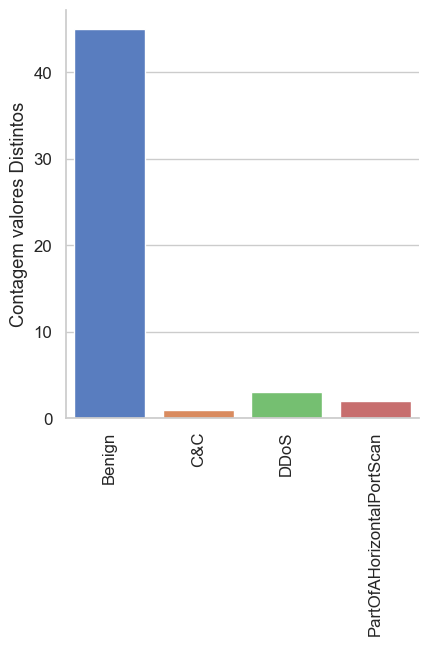

In [445]:
respH_nunique_label = sns.catplot(
    data = data.groupby('label')['id.resp_h'].nunique().reset_index(),
    kind = "bar",
    x='label', y='id.resp_h',
    hue = 'label'
).set(xlabel=None).set(ylabel='Contagem valores Distintos')
plt.xticks(rotation=90);

In [446]:
data.groupby('label')['id.resp_p'].nunique().reset_index()

,label,id.resp_p
0,Benign,6
1,C&C,1
2,DDoS,2
3,PartOfAHorizontalPortScan,2


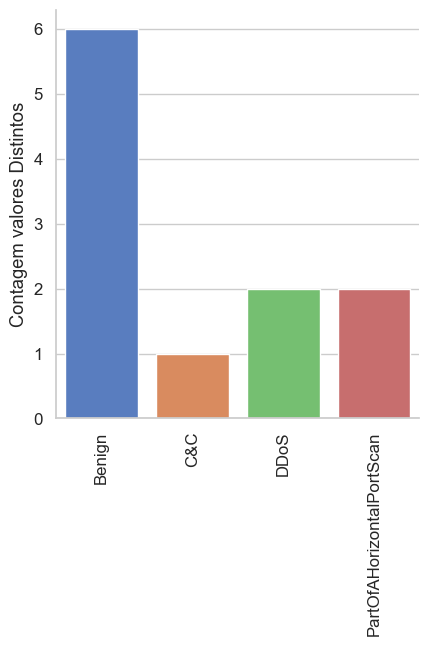

In [447]:
respP_nunique_label = sns.catplot(
    data = data.groupby('label')['id.resp_p'].nunique().reset_index(),
    kind = "bar",
    x='label', y='id.resp_p',
    hue = 'label'
).set(xlabel=None).set(ylabel='Contagem valores Distintos')
plt.xticks(rotation=90);

In [448]:
data_labels_agg.groupby(['label']).mean()['avg_byte_pkts']

label
Benign                        45.410279
C&C                            3.405380
DDoS                         315.076923
PartOfAHorizontalPortScan    372.363636
Name: avg_byte_pkts, dtype: float64

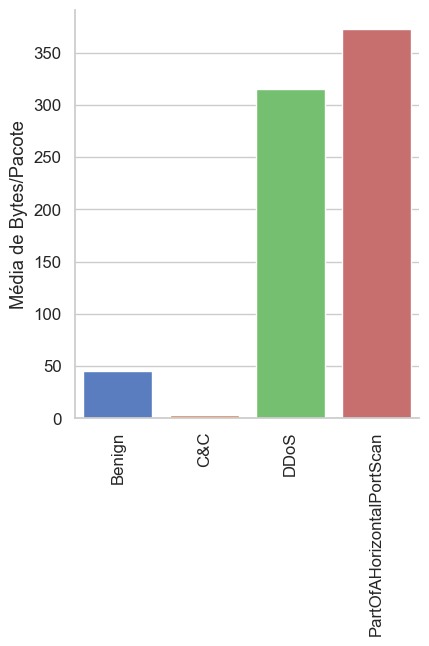

In [449]:
avgBytesPkts_mean_label = sns.catplot(
    data = data_labels_agg.groupby(['label']).mean(),
    kind = "bar",
    x='label', y='avg_byte_pkts',
    hue = 'label'
).set(xlabel=None).set(ylabel='Média de Bytes/Pacote')
plt.xticks(rotation=90);

**Preprocessamento dos dados**

Dados na tabela final:

Duration -> scale <br>
avg_bytes_pkts -> scale <br>
hist_len -> scale <br>

history types -> one hot  <br>
conn_state -> cat -> one hot <br>
proto -> cat -> one hot 

In [450]:
pre_proc_cols = [
    'avg_byte_pkts',
    'hist_len',
    'proto',
    'duration',
    'conn_state',
    'history',
    'label'
]

In [451]:
data_pre_proc = data[pre_proc_cols]
data_pre_proc

,avg_byte_pkts,hist_len,proto,duration,conn_state,history,label
0,0.000000,1,tcp,3.139211,S0,S,Benign
1,NaN,1,tcp,NaN,S0,S,Benign
2,NaN,1,tcp,NaN,S0,S,Benign
3,1.585106,11,tcp,1.477656,SF,ShADadttcfF,Benign
4,0.000000,1,tcp,3.147116,S0,S,Benign
...,...,...,...,...,...,...,...
23140,8.857143,7,tcp,32.840996,S3,ShAdDaf,C&C
23141,6.200000,7,tcp,36.290833,S3,ShAdDaf,C&C
23142,NaN,1,udp,NaN,S0,D,Benign
23143,NaN,1,udp,NaN,S0,D,Benign


In [452]:
data_pre_proc.loc[:,['avg_byte_pkts','hist_len','duration']] = data_pre_proc[['avg_byte_pkts','hist_len','duration']].fillna(0)

In [453]:
scaler = StandardScaler()
std_scaled_data = scaler.fit_transform(
    data_pre_proc[['avg_byte_pkts','hist_len','duration']]
)

In [454]:
data_pre_proc.loc[:,['avg_byte_pkts','hist_len','duration']] = std_scaled_data
data_pre_proc

/var/folders/rl/j6h8h7717_9dr246dl78zklm0000gn/T/ipykernel_52559/1261424295.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.30002415 -0.30002415 -0.30002415 ... -0.30002415 -0.30002415
 -0.30002415]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_pre_proc.loc[:,['avg_byte_pkts','hist_len','duration']] = std_scaled_data
/var/folders/rl/j6h8h7717_9dr246dl78zklm0000gn/T/ipykernel_52559/1261424295.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.00607148 -0.01513038 -0.01513038 ... -0.01513038 -0.01513038
 -0.01513038]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  data_pre_proc.loc[:,['avg_byte_pkts','hist_len','duration']] = std_scaled_data


,avg_byte_pkts,hist_len,proto,duration,conn_state,history,label
0,-0.075083,-0.300024,tcp,-0.006071,S0,S,Benign
1,-0.075083,-0.300024,tcp,-0.015130,S0,S,Benign
2,-0.075083,-0.300024,tcp,-0.015130,S0,S,Benign
3,-0.034788,6.054930,tcp,-0.010866,SF,ShADadttcfF,Benign
4,-0.075083,-0.300024,tcp,-0.006049,S0,S,Benign
...,...,...,...,...,...,...,...
23140,0.150072,3.512949,tcp,0.079640,S3,ShAdDaf,C&C
23141,0.082526,3.512949,tcp,0.089595,S3,ShAdDaf,C&C
23142,-0.075083,-0.300024,udp,-0.015130,S0,D,Benign
23143,-0.075083,-0.300024,udp,-0.015130,S0,D,Benign


In [455]:
cols_ohe = pd.get_dummies(data_pre_proc[['proto','conn_state','history']])
cols_ohe

,proto_tcp,proto_udp,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF,history_C,history_CCC,...,history_ShAdD,history_ShAdDa,history_ShAdDaf,history_ShAdDaft,history_ShAdDatf,history_ShAdDatfr,history_ShAdDfr,history_ShAdfDr,history_ShAfdtDr,history_ShDadAf
0,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,True,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
23141,True,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
23142,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23143,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [456]:
data_pre_proc = pd.concat([data_pre_proc,cols_ohe],axis=1)
data_pre_proc

,avg_byte_pkts,hist_len,proto,duration,conn_state,history,label,proto_tcp,proto_udp,conn_state_OTH,...,history_ShAdD,history_ShAdDa,history_ShAdDaf,history_ShAdDaft,history_ShAdDatf,history_ShAdDatfr,history_ShAdDfr,history_ShAdfDr,history_ShAfdtDr,history_ShDadAf
0,-0.075083,-0.300024,tcp,-0.006071,S0,S,Benign,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.075083,-0.300024,tcp,-0.015130,S0,S,Benign,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.075083,-0.300024,tcp,-0.015130,S0,S,Benign,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.034788,6.054930,tcp,-0.010866,SF,ShADadttcfF,Benign,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.075083,-0.300024,tcp,-0.006049,S0,S,Benign,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,0.150072,3.512949,tcp,0.079640,S3,ShAdDaf,C&C,True,False,False,...,False,False,True,False,False,False,False,False,False,False
23141,0.082526,3.512949,tcp,0.089595,S3,ShAdDaf,C&C,True,False,False,...,False,False,True,False,False,False,False,False,False,False
23142,-0.075083,-0.300024,udp,-0.015130,S0,D,Benign,False,True,False,...,False,False,False,False,False,False,False,False,False,False
23143,-0.075083,-0.300024,udp,-0.015130,S0,D,Benign,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [457]:
data_pre_proc = data_pre_proc.drop(columns=['proto','conn_state','history'])

In [458]:
nl_data_pre_proc = data_pre_proc.drop(columns=['label'])
nl_data_pre_proc

,avg_byte_pkts,hist_len,duration,proto_tcp,proto_udp,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,...,history_ShAdD,history_ShAdDa,history_ShAdDaf,history_ShAdDaft,history_ShAdDatf,history_ShAdDatfr,history_ShAdDfr,history_ShAdfDr,history_ShAfdtDr,history_ShDadAf
0,-0.075083,-0.300024,-0.006071,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.075083,-0.300024,-0.015130,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.075083,-0.300024,-0.015130,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.034788,6.054930,-0.010866,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.075083,-0.300024,-0.006049,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,0.150072,3.512949,0.079640,True,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
23141,0.082526,3.512949,0.089595,True,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
23142,-0.075083,-0.300024,-0.015130,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
23143,-0.075083,-0.300024,-0.015130,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [459]:
pca = PCA(n_components=2)
fit_pca = pca.fit_transform(nl_data_pre_proc)

In [460]:
df_pca = pd.DataFrame(fit_pca, columns=['PC1','PC2'])
df_pca_labeled = pd.concat([df_pca,data_pre_proc['label']],axis=1)
print(df_pca_labeled)

            PC1       PC2   label
0     -0.005445 -0.041109  Benign
1     -0.007288 -0.048206  Benign
2     -0.007288 -0.048206  Benign
3      5.178900  0.424754  Benign
4     -0.005441 -0.041091  Benign
...         ...       ...     ...
23140  3.542811  0.250649     C&C
23141  3.521926  0.299561     C&C
23142  0.073736 -0.144890  Benign
23143  0.073736 -0.144890  Benign
23144  0.073736 -0.144890  Benign

[23145 rows x 3 columns]


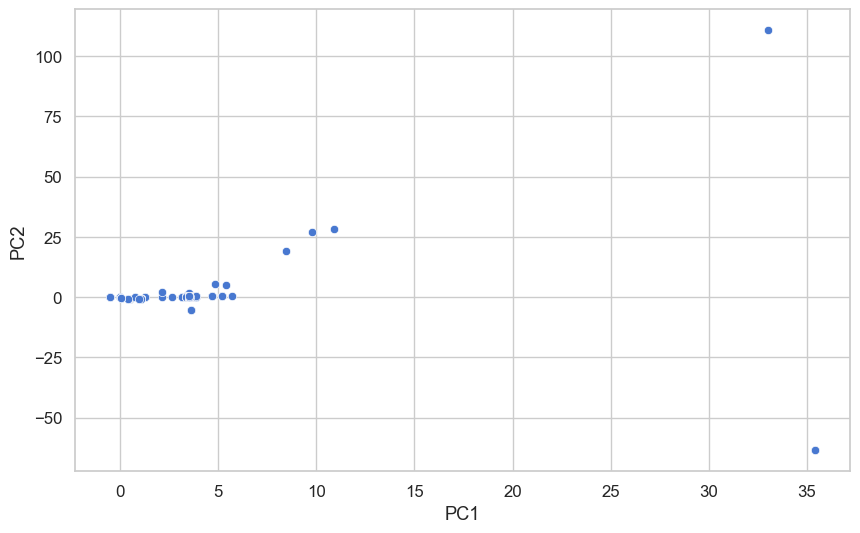

In [497]:
sns.scatterplot(
    data=df_pca_labeled,
    x='PC1',
    y='PC2'
);

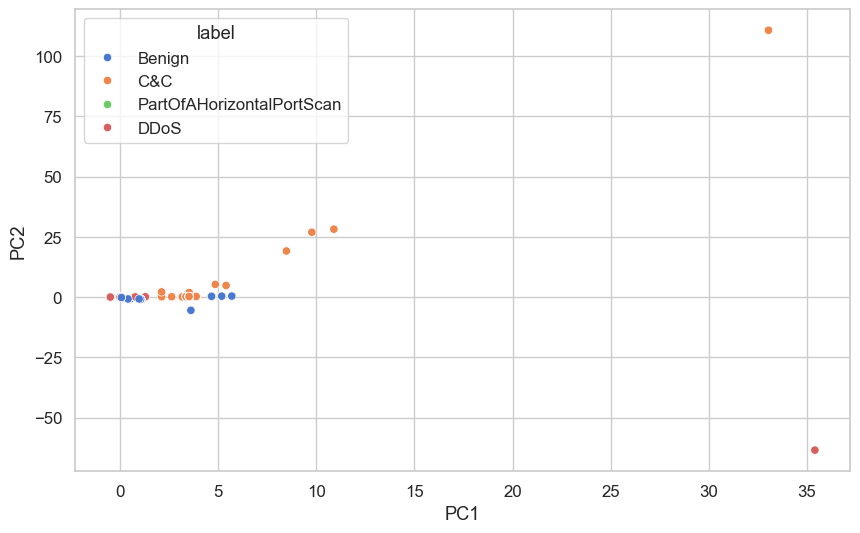

In [461]:
sns.scatterplot(
    data=df_pca_labeled,
    x='PC1',
    y='PC2',
    hue='label'
);

In [462]:
fit_tsne = TSNE(n_components=2, 
                  learning_rate='auto',
                  init='random',
                  perplexity=3
                 ).fit_transform(nl_data_pre_proc)

In [463]:
df_fit_tsne = pd.DataFrame(fit_tsne, columns=['T1','T2'])
df_fit_tsne_labeled = pd.concat([df_fit_tsne,data_pre_proc['label']],axis=1)
df_fit_tsne_labeled

,T1,T2,label
0,14.344193,39.107712,Benign
1,30.562759,10.834969,Benign
2,30.562752,10.835247,Benign
3,8.188887,-9.140689,Benign
4,19.855001,-34.444740,Benign
...,...,...,...
23140,16.889950,-31.180435,C&C
23141,33.158203,-20.348442,C&C
23142,16.184265,-0.475845,Benign
23143,15.314499,-0.592192,Benign


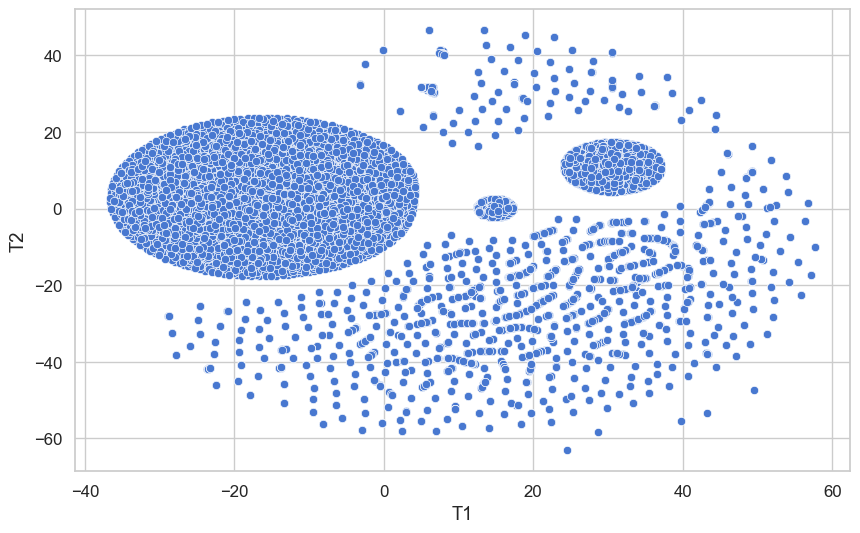

In [498]:
sns.scatterplot(
    data=df_fit_tsne_labeled,
    x='T1',
    y='T2'
);

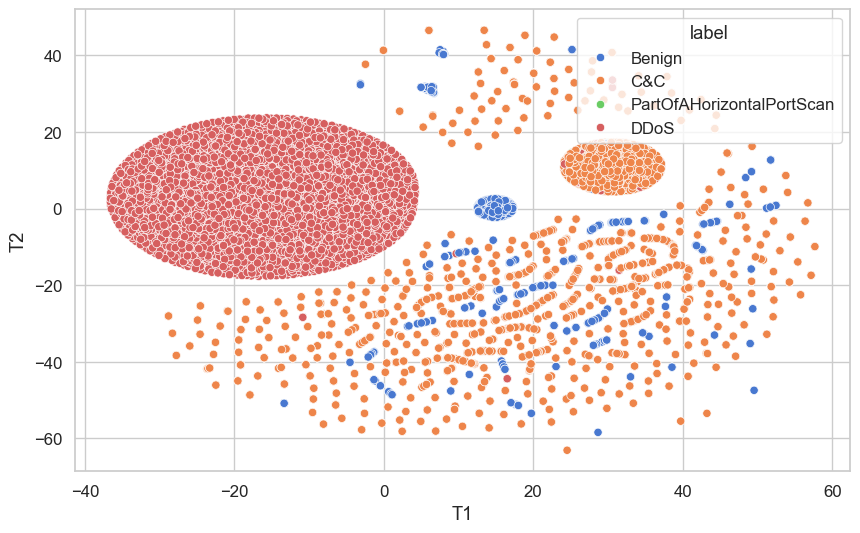

In [464]:
sns.scatterplot(
    data=df_fit_tsne_labeled,
    x='T1',
    y='T2',
    hue='label'
);

In [465]:
fit_tsne_pca = TSNE(n_components=2, 
                  learning_rate='auto',
                  init='random',
                  perplexity=3
                 ).fit_transform(fit_pca)

In [466]:
df_fit_tsne_pca = pd.DataFrame(fit_tsne_pca, columns=['T1','T2'])
df_fit_tsne_pca_labeled = pd.concat([df_fit_tsne_pca,data_pre_proc['label']],axis=1)
df_fit_tsne_pca_labeled

,T1,T2,label
0,-6.313096,-45.445766,Benign
1,7.605210,32.147465,Benign
2,7.605210,32.147465,Benign
3,28.139200,-16.613214,Benign
4,6.734489,-45.483154,Benign
...,...,...,...
23140,35.285255,-3.784769,C&C
23141,25.874083,-15.388321,C&C
23142,14.277698,-5.376021,Benign
23143,13.564632,-4.845573,Benign


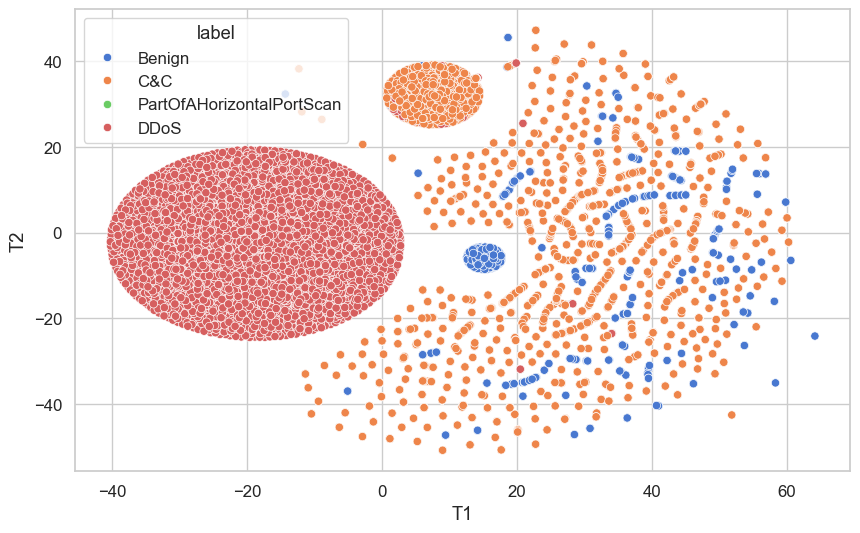

In [467]:
sns.scatterplot(
    data=df_fit_tsne_pca_labeled,
    x='T1',
    y='T2',
    hue='label'
);

In [499]:
K = range(2, 8)
fits = []
score = []


for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(nl_data_pre_proc)
    
    # append the model to fits
    fits.append(model)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(nl_data_pre_proc, model.labels_, metric='euclidean'))

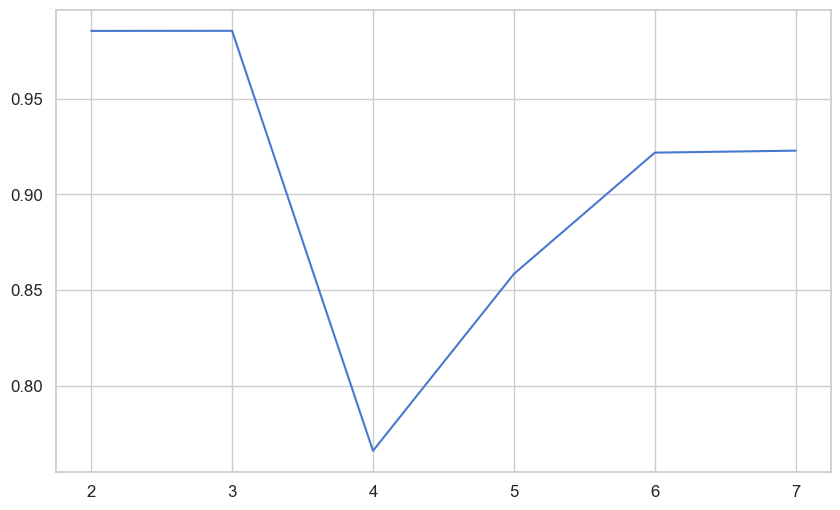

In [500]:
sns.lineplot(x = K, y = score);

In [485]:
kmean_pca = KMeans(n_clusters = 4, random_state = 0, n_init='auto')
kmean_pca.fit(df_pca)

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,0
,copy_x,True
,algorithm,'lloyd'


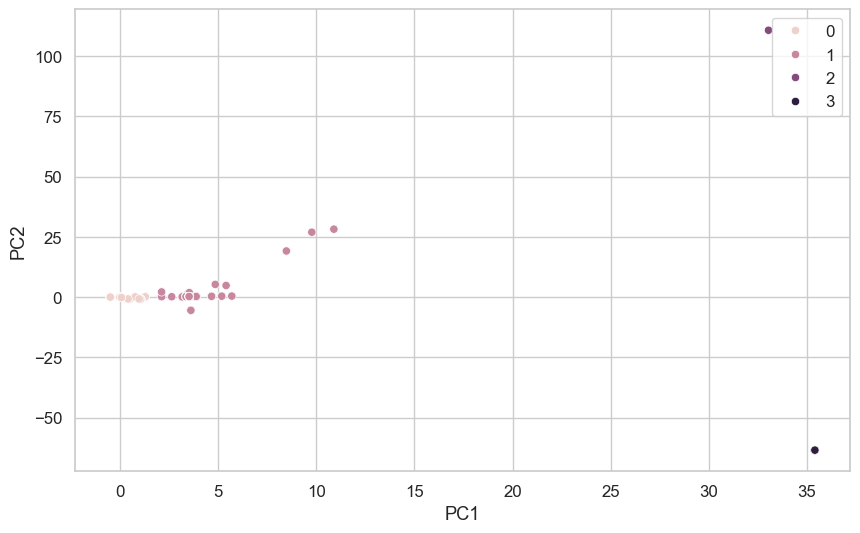

In [486]:
sns.scatterplot(data = df_pca, x = 'PC1', y = 'PC2', hue = kmean_pca.labels_);

In [488]:
kmean_tsne = KMeans(n_clusters = 4, random_state = 0, n_init='auto')
kmean_tsne.fit(df_fit_tsne)

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,0
,copy_x,True
,algorithm,'lloyd'


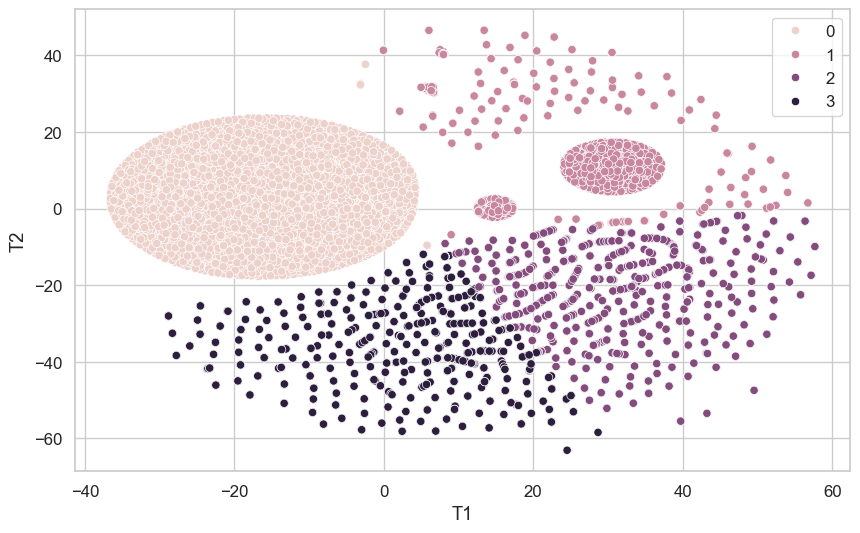

In [490]:
sns.scatterplot(data = df_fit_tsne, x = 'T1', y = 'T2', hue = kmean_tsne.labels_);

In [503]:
kmean_tsne_5 = KMeans(n_clusters = 5, random_state = 0, n_init='auto')
kmean_tsne_5.fit(df_fit_tsne)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,0
,copy_x,True
,algorithm,'lloyd'


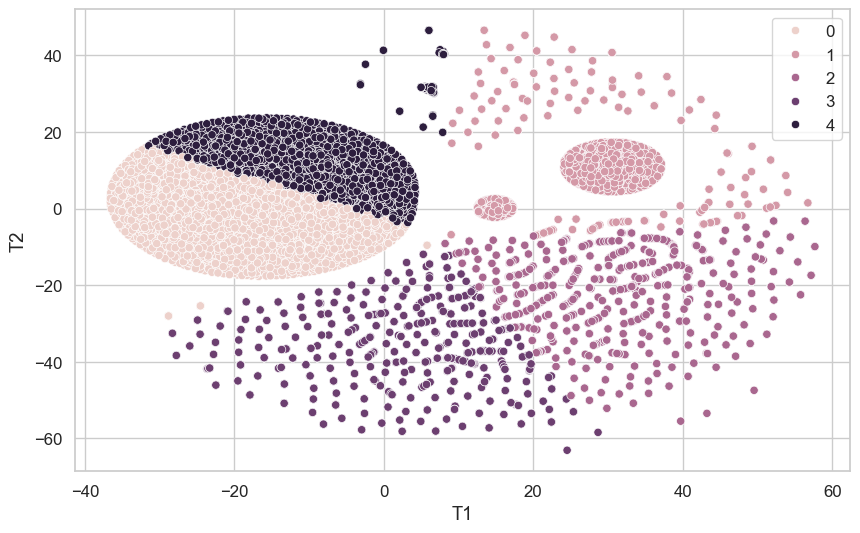

In [504]:
sns.scatterplot(data = df_fit_tsne, x = 'T1', y = 'T2', hue = kmean_tsne_5.labels_);

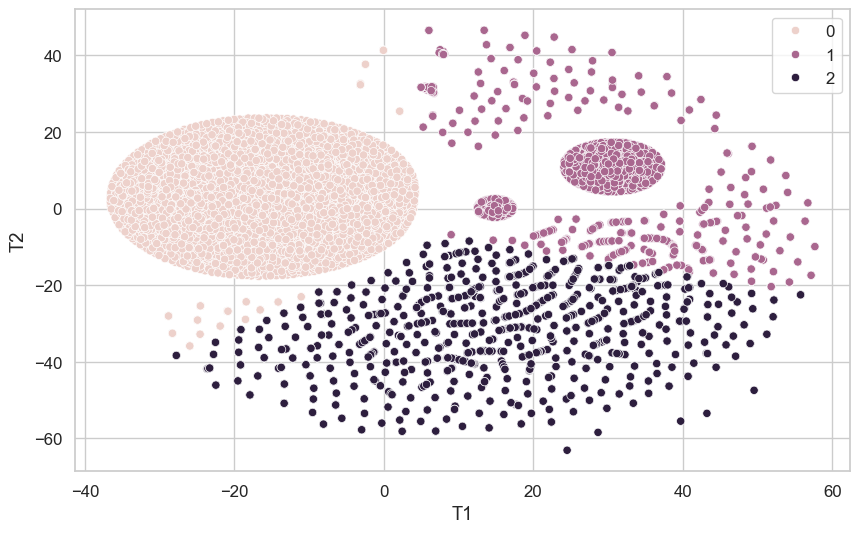

In [505]:
kmean_tsne_3 = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmean_tsne_3.fit(df_fit_tsne)
sns.scatterplot(data = df_fit_tsne, x = 'T1', y = 'T2', hue = kmean_tsne_3.labels_);